# Arbitrum Poison Hunter

Detect address poisoning attacks on the Arbitrum chain for USDC and USDT stablecoins.


## DATA PREP

### Option 1: Pull from BigQuery


In [ ]:
# %%bigquery step_1_df
# SELECT 
#   block_hash,
#   block_number,
#   block_timestamp,
#   transaction_hash,
#   transaction_index,
#   log_index,
#   address,
#   data,
#   removed,
#   ARRAY_TO_STRING(topics, ',') AS topics_csv
# FROM `bigquery-public-data.goog_blockchain_arbitrum_one_us.logs` 
# WHERE block_timestamp >= TIMESTAMP("2025-11-01")
#   AND block_timestamp < TIMESTAMP("2025-12-01")   


### Option 2: Load from CSV (arbitrum_txs.csv)


In [17]:
import pandas as pd
from tqdm.auto import tqdm

# Enable tqdm for pandas
tqdm.pandas()

# Load raw logs from CSV
print("Loading CSV file...")
raw_df = pd.read_csv('arbitrum_txs.csv')
print(f"Loaded {len(raw_df):,} raw log rows")

# Parse topics from comma-separated string
print("\nParsing topics...")
raw_df['topics'] = raw_df['topics_csv'].str.split(',')

# Filter for Transfer events only (topic[0] = Transfer signature)
# Handle NaN values by checking if x is a list first
print("Filtering for Transfer events...")
TRANSFER_SIGNATURE = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'
transfer_df = raw_df[raw_df['topics'].progress_apply(
    lambda x: isinstance(x, list) and len(x) >= 3 and x[0] == TRANSFER_SIGNATURE
)].copy()
print(f"Found {len(transfer_df):,} Transfer events")

# Filter for USDC and USDT tokens
USDC_NATIVE = '0xaf88d065e77c8cc2239327c5edb3a432268e5831'
USDC_BRIDGED = '0xff970a61a04b1ca14834a43f5de4533ebddb5cc8'
USDT = '0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9'

transfer_df = transfer_df[transfer_df['address'].str.lower().isin([USDC_NATIVE, USDC_BRIDGED, USDT])].copy()
print(f"Filtered to {len(transfer_df):,} USDC/USDT transfers")

# Extract from_address and to_address from topics (last 40 chars of 32-byte hex)
print("\nExtracting addresses...")
transfer_df['from_address'] = transfer_df['topics'].progress_apply(lambda x: '0x' + x[1][-40:])
transfer_df['to_address'] = transfer_df['topics'].progress_apply(lambda x: '0x' + x[2][-40:])

# Convert hex data to numeric value
print("\nConverting values...")
transfer_df['value'] = transfer_df['data'].progress_apply(lambda x: int(x, 16) if pd.notna(x) and x != '0x' else 0)
transfer_df['value_usd'] = transfer_df['value'] / 1_000_000  # USDC/USDT have 6 decimals

# Rename address to token_address for consistency
transfer_df['token_address'] = transfer_df['address']

# Convert timestamp
transfer_df['block_timestamp'] = pd.to_datetime(transfer_df['block_timestamp'])

# Exclude self-transfers
transfer_df = transfer_df[transfer_df['from_address'] != transfer_df['to_address']]

# Select final columns
step_1_df = transfer_df[['block_number', 'block_timestamp', 'token_address', 
                          'from_address', 'to_address', 'value', 'value_usd', 
                          'transaction_hash']].copy()

# Sort by timestamp
step_1_df = step_1_df.sort_values('block_timestamp').reset_index(drop=True)

# Display basic info about the loaded data
print(f"\n{'='*50}")
print(f"Loaded {len(step_1_df):,} token transfer rows")
print(f"Date range: {step_1_df['block_timestamp'].min()} to {step_1_df['block_timestamp'].max()}")
print(f"Token addresses: {step_1_df['token_address'].unique()}")
step_1_df.head()


Loading CSV file...
Loaded 1,000,000 raw log rows

Parsing topics...
Filtering for Transfer events...


100%|██████████| 1000000/1000000 [00:00<00:00, 2904940.40it/s]


Found 685,132 Transfer events
Filtered to 366,109 USDC/USDT transfers

Extracting addresses...


100%|██████████| 366109/366109 [00:00<00:00, 2826401.16it/s]



Converting values...


100%|██████████| 366109/366109 [00:00<00:00, 1433613.83it/s]



Loaded 366,088 token transfer rows
Date range: 2025-11-30 19:07:13+00:00 to 2025-11-30 22:42:53+00:00
Token addresses: ['0xaf88d065e77c8cc2239327c5edb3a432268e5831'
 '0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9'
 '0xff970a61a04b1ca14834a43f5de4533ebddb5cc8']


,block_number,block_timestamp,token_address,from_address,to_address,value,value_usd,transaction_hash
0,405793176,2025-11-30 19:07:13+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0x4098503de63ca5c0686c1cc952138f928b7b9aab,0x981852aafd7333f33da7dd7ef15b2ab08f91c62c,0,0.0,0xaaf5870a036b74b8430f1a87e103858b03ef14321445...
1,405793176,2025-11-30 19:07:13+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0xe8cb5d0ff057a655b659604a05a50d8ca3b80a49,0xf2259341579061c8f335a1042439cf4f43faa9a9,0,0.0,0xaaf5870a036b74b8430f1a87e103858b03ef14321445...
2,405793176,2025-11-30 19:07:13+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0x52d0fc347560cc997f87984200f4a9344ecdc597,0x0decd59b7b7fe3106dc3730d8c0c7ee9db920eb7,0,0.0,0xaaf5870a036b74b8430f1a87e103858b03ef14321445...
3,405793176,2025-11-30 19:07:13+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0x0240807c41f212d2c94647172f6b526b5b0a0449,0x0f3d43d45177330c241e2b5d7f59af27e9b004d2,0,0.0,0xaaf5870a036b74b8430f1a87e103858b03ef14321445...
4,405793176,2025-11-30 19:07:13+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0xfd1768bfd891220ee0d5ff9cf548f90c40911ec4,0x60f0308c8d4611c95bbe537f20612e9c1e6f5da5,0,0.0,0xaaf5870a036b74b8430f1a87e103858b03ef14321445...


## Step 1: Block Filtering


In [3]:
import pandas as pd

min_block = step_1_df['block_number'].min()
max_block = step_1_df['block_number'].max()

def filter_by_block(start_block: int, end_block: int, df: pd.DataFrame = step_1_df) -> pd.DataFrame:
    """
    Filters a pandas DataFrame by block_number range and returns a new DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame containing a 'block_number' column.
        start_block (int): Minimum block_number (inclusive).
        end_block (int): Maximum block_number (inclusive).

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    if 'block_number' not in df.columns:
        raise ValueError("DataFrame must contain a 'block_number' column.")
    
    filtered_df = df[(df['block_number'] >= start_block) & (df['block_number'] <= end_block)]
    return filtered_df

print(f"min block: {min_block}")
print(f"max block: {max_block}")
print(f"total blocks: {max_block - min_block + 1}")


min block: 405793176
max block: 405845049
total blocks: 51874


## Step 2: Identify Suspicious Transactions (Zero-value and Dust Attacks)


In [4]:
import pandas as pd
import numpy as np
from typing import Set, Any

def step2_vectorized(window_dataframe, block_1):
    """
    Identify zero-value and dust attacks in a search window.
    
    Args:
        window_dataframe: DataFrame of transactions in the search window
        block_1: DataFrame of original victim transactions
    
    Returns:
        DataFrame of suspicious transactions with attacker/victim info
    """
    victim_set = set(block_1['from_address'])
    
    # Build victim -> tx_hashes mapping
    victim_to_tx_hashes = block_1.groupby('from_address')['transaction_hash'].apply(set).to_dict()
    
    # Vectorized conditions
    mask_zero = (window_dataframe['value_usd'] == 0) & (window_dataframe['from_address'].isin(victim_set))
    mask_dust = (window_dataframe['value_usd'] > 0) & (window_dataframe['value_usd'] <= 1) & (window_dataframe['to_address'].isin(victim_set))
    
    combined_mask = mask_zero | mask_dust
    
    # Early return if no matches
    if not combined_mask.any():
        return pd.DataFrame(columns=list(window_dataframe.columns) + ['attacker_address', 'victim_address', 'victim_tx_hash', 'attack_type'])
    
    # Filter matching rows
    suspicious_transactions = window_dataframe[combined_mask].copy()
    
    # Get the mask subset for proper alignment
    mask_zero_subset = mask_zero[combined_mask]
    
    # Set attacker address based on which condition matched
    suspicious_transactions['attacker_address'] = np.where(
        mask_zero_subset,
        suspicious_transactions['to_address'],
        suspicious_transactions['from_address']
    )
    
    # Set victim address (opposite of attacker)
    suspicious_transactions['victim_address'] = np.where(
        mask_zero_subset,
        suspicious_transactions['from_address'],
        suspicious_transactions['to_address']
    )
    
    # Set victim tx hash using the mapping
    suspicious_transactions['victim_tx_hash'] = suspicious_transactions['victim_address'].map(
        lambda addr: victim_to_tx_hashes.get(addr, set())
    )
    
    # Set attack type
    suspicious_transactions['attack_type'] = np.where(
        mask_zero_subset,
        'zero',
        'dust'
    )
    
    return suspicious_transactions

print("step2_vectorized function defined")


step2_vectorized function defined


### Step 2: Execute (Optimized Bulk Processing)


In [5]:
import numpy as np
import time
from tqdm.auto import tqdm

# Configuration
BLOCK_WINDOW = 4800  # Search window size
NUM_BLOCKS = 5800   # Number of blocks to process (adjust as needed)

start_time = time.time()

# Define block range
victim_blocks = np.arange(min_block, min_block + NUM_BLOCKS)

# Victim df = all transactions in those blocks
victim_df = step_1_df[step_1_df['block_number'].isin(victim_blocks)].copy()

# Window df = all transactions that could appear in any search window
search_min = min_block + 1
search_max = (min_block + NUM_BLOCKS - 1) + BLOCK_WINDOW + 1 

window_df = step_1_df[
    (step_1_df['block_number'] >= search_min) &
    (step_1_df['block_number'] <= search_max)
].copy()

# Build mapping: search_block → victim_block(s)
print("Building block mapping...")
search_unique_blocks = window_df['block_number'].unique()

mapping_rows = []
for b_s in tqdm(search_unique_blocks, desc="Mapping blocks"):
    v_low = b_s - BLOCK_WINDOW - 1
    v_high = b_s - 1
    valid_victims = victim_blocks[(victim_blocks >= v_low) & (victim_blocks <= v_high)]
    for v in valid_victims:
        mapping_rows.append((b_s, v))

block_map = pd.DataFrame(mapping_rows, columns=['search_block', 'victim_block'])

# Merge the mapping with window_df
window_df2 = window_df.merge(
    block_map,
    left_on='block_number',
    right_on='search_block',
    how='right'
).drop(columns=['search_block'])

# Group victims by block
victim_groups = {blk: grp for blk, grp in victim_df.groupby('block_number')}

# Run step2_vectorized in bulk
print("\nProcessing victim blocks...")
results = []
grouped = list(window_df2.groupby('victim_block'))
for v_block, win_grp in tqdm(grouped, desc="Scanning for attacks"):
    victim_block_df = victim_groups.get(v_block)
    if victim_block_df is None:
        continue
    out = step2_vectorized(win_grp, victim_block_df)
    if not out.empty:
        out['victim_block_number'] = v_block
        results.append(out)

# Combine results
step_2_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()

end_time = time.time()
print(f"\nStep 2 completed for {NUM_BLOCKS} blocks in {end_time - start_time:.2f} seconds")
print(f"Found {len(step_2_df)} suspicious transactions")


Building block mapping...


Mapping blocks: 100%|██████████| 6895/6895 [00:01<00:00, 6739.64it/s] 



Processing victim blocks...


Scanning for attacks: 100%|██████████| 5800/5800 [00:12<00:00, 451.59it/s]



Step 2 completed for 5800 blocks in 94.21 seconds
Found 84661 suspicious transactions


## Step 3: Identify Lookalike Addresses


In [6]:
from typing import Tuple

def calculate_similarity_score(addr1: str, addr2: str) -> Tuple[int, int]:
    """
    Calculate prefix and suffix match length between two addresses.
    Case-insensitive comparison, ignores '0x' prefix.
    """
    addr1 = addr1.lower()
    addr2 = addr2.lower()
    
    if addr1.startswith('0x'):
        addr1 = addr1[2:]
    if addr2.startswith('0x'):
        addr2 = addr2[2:]
    
    # Calculate prefix match
    prefix_match = 0
    for c1, c2 in zip(addr1, addr2):
        if c1 == c2:
            prefix_match += 1
        else:
            break
    
    # Calculate suffix match
    suffix_match = 0
    for c1, c2 in zip(reversed(addr1), reversed(addr2)):
        if c1 == c2:
            suffix_match += 1
        else:
            break
    
    return prefix_match, suffix_match


def step3_extract_lookalikes_optimized(
    step2_df: pd.DataFrame,
    original_df: pd.DataFrame,
    min_prefix: int = 3,
    min_suffix: int = 4,
    show_progress: bool = True
) -> pd.DataFrame:
    """
    Extract lookalike addresses from step2 output.
    Uses victim_tx_hash from step2_df to find intended addresses from original transactions.
    """
    from tqdm.auto import tqdm
    
    new_columns = ['intended_address', 'prefix_match', 'suffix_match', 'attacker_transaction_hash', 'victim_transaction_hash', 'time_since_victim_tx', 'is_lookalike']
    
    if step2_df.empty:
        return pd.DataFrame(columns=list(step2_df.columns) + new_columns)
    
    # Build transaction_hash -> to_address mapping from original data
    tx_hash_to_recipient = original_df.set_index('transaction_hash')['to_address'].to_dict()
    
    # Build transaction_hash -> block_timestamp mapping for time delta calculation
    tx_hash_to_timestamp = original_df.set_index('transaction_hash')['block_timestamp'].to_dict()
    
    # Get unique (attacker, victim) pairs for efficient computation
    unique_pairs = step2_df[['attacker_address', 'victim_address', 'victim_tx_hash']].drop_duplicates(
        subset=['attacker_address', 'victim_address']
    )
    
    # Compute best matches for each unique pair
    results = []
    iterator = unique_pairs.iterrows()
    if show_progress:
        iterator = tqdm(list(iterator), desc="Analyzing lookalikes")
    
    for _, row in iterator:
        attacker = row['attacker_address']
        victim = row['victim_address']
        victim_tx_hashes = row['victim_tx_hash']
        
        # Get intended addresses from victim's transaction hashes
        intended_set = {tx_hash_to_recipient.get(tx_hash) for tx_hash in victim_tx_hashes if tx_hash in tx_hash_to_recipient}
        intended_set.discard(None)
        
        best_intended = None
        best_prefix = 0
        best_suffix = 0
        
        for intended in intended_set:
            p, s = calculate_similarity_score(attacker, intended)
            if (p + s) > (best_prefix + best_suffix):
                best_intended = intended
                best_prefix = p
                best_suffix = s
        
        # Find earliest victim transaction timestamp
        victim_timestamps = [tx_hash_to_timestamp.get(tx_hash) for tx_hash in victim_tx_hashes if tx_hash in tx_hash_to_timestamp]
        earliest_victim_ts = min(victim_timestamps) if victim_timestamps else None
        
        results.append({
            'attacker_address': attacker,
            'victim_address': victim,
            'intended_address': best_intended,
            'prefix_match': best_prefix,
            'suffix_match': best_suffix,
            'victim_timestamp': earliest_victim_ts
        })
    
    # Create lookup DataFrame and merge
    lookup_df = pd.DataFrame(results)
    result_df = step2_df.merge(lookup_df, on=['attacker_address', 'victim_address'], how='left')
    
    # Add transaction hash columns
    result_df['attacker_transaction_hash'] = result_df['transaction_hash']
    result_df['victim_transaction_hash'] = result_df['victim_tx_hash']
    
    # Calculate time since victim transaction (attack timestamp - victim timestamp)
    result_df['time_since_victim_tx'] = result_df['block_timestamp'] - result_df['victim_timestamp']
    
    # Add is_lookalike flag
    result_df['is_lookalike'] = (
        (result_df['prefix_match'] >= min_prefix) & 
        (result_df['suffix_match'] >= min_suffix)
    )
    
    return result_df

print("Step 3 functions defined")


Step 3 functions defined


### Step 3: Execute


In [7]:
# Run Step 3 - uses victim_tx_hash from step2_df to find intended addresses
step_3_df = step3_extract_lookalikes_optimized(
    step2_df=step_2_df,
    original_df=step_1_df,
    min_prefix=3,
    min_suffix=4
)

# Filter to confirmed attacks only
confirmed_attacks = step_3_df[step_3_df['is_lookalike'] == True]

print(f"Total suspicious transactions: {len(step_3_df)}")
print(f"Confirmed lookalike attacks: {len(confirmed_attacks)}")


Analyzing lookalikes: 100%|██████████| 15452/15452 [00:00<00:00, 327623.02it/s]

Total suspicious transactions: 84661
Confirmed lookalike attacks: 1377


## Results


In [8]:
# View confirmed attacks
confirmed_attacks[['attacker_address', 'victim_address', 'intended_address', 
                   'prefix_match', 'suffix_match', 'attack_type', 
                   'attacker_transaction_hash', 'victim_transaction_hash']].head(20)


,attacker_address,victim_address,intended_address,prefix_match,suffix_match,attack_type,attacker_transaction_hash,victim_transaction_hash
253,0x09999a44218e9a6e15bbd79a953f39143ebf077e,0xcd270e264e1123aa0bbe75b11a4554a40fa3c7cc,0x09999a44218e9a6e15bbd79a953f39143ebf077e,40,40,zero,0xa8ce4977711a44b205cca5f478dff9a7b2e52dac3990...,{0xaaf5870a036b74b8430f1a87e103858b03ef1432144...
796,0x09995c02146ae70af4d1bc8ec6d001e264ca077e,0xcd270e264e1123aa0bbe75b11a4554a40fa3c7cc,0x09999a44218e9a6e15bbd79a953f39143ebf077e,4,4,zero,0x563b03d81ad45fe0867d3f72e90a040b40dd250bc148...,{0xaaf5870a036b74b8430f1a87e103858b03ef1432144...
1358,0x13f7128fb6600c98c50ad5ab706410c00eb4c0df,0xacaadd099de7a52fca44425052cff7db1989dac6,0x13f7010a8571e80e18cc01ca9e94c52b453ac0df,4,4,zero,0x69537f2d66ee49bbd0b0a0a6fbcc091531b375fd3a73...,{0x8f3a638ef2009b9ad366b6ce8f81ef261ee57c25e05...
1378,0xccd5891083a8acd2074690f65d3024e7d13d66e7,0x827ed82288bdee6f207d2927eec89ff16a493731,0xccd5891083a8acd2074690f65d3024e7d13d66e7,40,40,dust,0xa337340a1655beeca54e870c58202c50666a68cc48be...,{0xc08fdf5090c6d3b3104a9099951b5b67e92025c72a1...
1379,0x9cfd06a0611a8a59db61c250ce557e55c9b0e8c6,0xd6f2d8fca2e606af2100f3b938cb22d7e61b7944,0x9cfd1059271742b9368876dc9bd8e168dd3de8c6,4,4,zero,0x508f9e0791e1b8f780c508cf631437f9a9bfab3549b0...,{0x94a9cadbb90c158f5a7334be4002fbe6af45631543c...
1395,0xccd5891083a8acd2074690f65d3024e7d13d66e7,0xca84a876c089012f3470a9574138bab8194f4746,0xccd5891083a8acd2074690f65d3024e7d13d66e7,40,40,dust,0x9f44d95458057c65c97cc57a65e553f1117ffd815465...,{0xe16a5c6563620ad72def994502e8bf6cdf2ce6d2480...
1444,0xccd5891083a8acd2074690f65d3024e7d13d66e7,0xe9e9adbb47c7da911b2fce7a6ee434359a97da9d,0xccd5891083a8acd2074690f65d3024e7d13d66e7,40,40,dust,0xeb975e3872d5bae111956e19afc882c95b4d90208fe8...,{0x979889acd7733dbae785b53031730d8664c2728dbb2...
2075,0xa1e3927ed3e6e76c7d4992f9e32d8d80c2b6706c,0x000006ffdd6e1a0acce7274522cc8c10dae3bfd9,0xa1e397b7efac7a7af4dc8580927270eb2ba7706c,5,4,zero,0xda08e46452fed82d3eb396b81e77d29d4f4e8726c81a...,{0xd288b55929c1081994fb543c1f6a4878fb5598b6ca0...
2076,0xdd512b9e5422e505973be17fc1811d08acfe2c63,0xdf04fa6ee5e2dcf73f7edd0aa3a5f7f9a4a5f445,0xdd512b9e5422e505973be17fc1811d08acfe2c63,40,40,dust,0x8aea351806c9e53338bec414de4a1baad3380a47f141...,{0xf66e720c138e7e06e6d061e28820040ec7df9b6d8ca...
2209,0x52aa899454998be5b000ad077a46bbe360f4e497,0x6c28f443c491f941def2fd983f4ce044e1c52a29,0x52aa899454998be5b000ad077a46bbe360f4e497,40,40,dust,0x324b7cc302feae0773ba9bc824d930c418e7431bbdf9...,{0x4f82780b734d3097ee979d1e39f7f3afacd9abd67dd...


In [9]:
# Save results to CSV (optional)
# confirmed_attacks.to_csv('arbitrumData/arbitrum_confirmed_attacks.csv', index=False)
# step_3_df.to_csv('arbitrumData/arbitrum_all_suspicious.csv', index=False)
# print("Results saved to arbitrumData/")


## Step 4: Post Processing

Filter out false positives where the attacker address fully matches the intended address.


In [10]:
# Filter out instances where prefix_match or suffix_match is 40 (full address match = likely false positive)
# An Ethereum address has 40 hex characters (excluding '0x'), so 40 = complete match

before_count = len(confirmed_attacks)

# Keep only rows where NEITHER prefix_match NOR suffix_match equals 40
filtered_attacks = confirmed_attacks[
    (confirmed_attacks['prefix_match'] != 40) & 
    (confirmed_attacks['suffix_match'] != 40)
].copy()

after_count = len(filtered_attacks)

print(f"Before filtering: {before_count} confirmed attacks")
print(f"Removed: {before_count - after_count} rows with full address overlap (40 chars)")
print(f"After filtering: {after_count} confirmed attacks")

filtered_attacks


Before filtering: 1377 confirmed attacks
Removed: 803 rows with full address overlap (40 chars)
After filtering: 574 confirmed attacks


,block_number,block_timestamp,token_address,from_address,to_address,value,value_usd,transaction_hash,victim_block,attacker_address,...,attack_type,victim_block_number,intended_address,prefix_match,suffix_match,victim_timestamp,attacker_transaction_hash,victim_transaction_hash,time_since_victim_tx,is_lookalike
796,405795492,2025-11-30 19:16:49+00:00,0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9,0xcd270e264e1123aa0bbe75b11a4554a40fa3c7cc,0x09995c02146ae70af4d1bc8ec6d001e264ca077e,0,0.0,0x563b03d81ad45fe0867d3f72e90a040b40dd250bc148...,405793176,0x09995c02146ae70af4d1bc8ec6d001e264ca077e,...,zero,405793176,0x09999a44218e9a6e15bbd79a953f39143ebf077e,4,4,2025-11-30 19:07:13+00:00,0x563b03d81ad45fe0867d3f72e90a040b40dd250bc148...,{0xaaf5870a036b74b8430f1a87e103858b03ef1432144...,0 days 00:09:36,True
1358,405795691,2025-11-30 19:17:39+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0xacaadd099de7a52fca44425052cff7db1989dac6,0x13f7128fb6600c98c50ad5ab706410c00eb4c0df,0,0.0,0x69537f2d66ee49bbd0b0a0a6fbcc091531b375fd3a73...,405793201,0x13f7128fb6600c98c50ad5ab706410c00eb4c0df,...,zero,405793201,0x13f7010a8571e80e18cc01ca9e94c52b453ac0df,4,4,2025-11-30 19:07:19+00:00,0x69537f2d66ee49bbd0b0a0a6fbcc091531b375fd3a73...,{0x8f3a638ef2009b9ad366b6ce8f81ef261ee57c25e05...,0 days 00:10:20,True
1379,405795583,2025-11-30 19:17:12+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0xd6f2d8fca2e606af2100f3b938cb22d7e61b7944,0x9cfd06a0611a8a59db61c250ce557e55c9b0e8c6,0,0.0,0x508f9e0791e1b8f780c508cf631437f9a9bfab3549b0...,405793207,0x9cfd06a0611a8a59db61c250ce557e55c9b0e8c6,...,zero,405793207,0x9cfd1059271742b9368876dc9bd8e168dd3de8c6,4,4,2025-11-30 19:07:20+00:00,0x508f9e0791e1b8f780c508cf631437f9a9bfab3549b0...,{0x94a9cadbb90c158f5a7334be4002fbe6af45631543c...,0 days 00:09:52,True
2075,405795791,2025-11-30 19:18:04+00:00,0xfd086bc7cd5c481dcc9c85ebe478a1c0b69fcbb9,0x000006ffdd6e1a0acce7274522cc8c10dae3bfd9,0xa1e3927ed3e6e76c7d4992f9e32d8d80c2b6706c,0,0.0,0xda08e46452fed82d3eb396b81e77d29d4f4e8726c81a...,405793278,0xa1e3927ed3e6e76c7d4992f9e32d8d80c2b6706c,...,zero,405793278,0xa1e397b7efac7a7af4dc8580927270eb2ba7706c,5,4,2025-11-30 19:07:38+00:00,0xda08e46452fed82d3eb396b81e77d29d4f4e8726c81a...,{0xd288b55929c1081994fb543c1f6a4878fb5598b6ca0...,0 days 00:10:26,True
2278,405795492,2025-11-30 19:16:49+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0xf00e2d3bec9089ccff9a859026be23745ddac3b6,0x028f5a5dddcaf9b28f57c86d1c7f5bbb3dbd3c9f,0,0.0,0x563b03d81ad45fe0867d3f72e90a040b40dd250bc148...,405793298,0x028f5a5dddcaf9b28f57c86d1c7f5bbb3dbd3c9f,...,zero,405793298,0x028f0fea5af8214c8818fdb5afbdad9e6c503c9f,4,4,2025-11-30 19:07:43+00:00,0x563b03d81ad45fe0867d3f72e90a040b40dd250bc148...,{0x33676c99dacb3a3305ded5c6bc063ec449b0e652922...,0 days 00:09:06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82779,405800965,2025-11-30 19:39:36+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0x16f22803f5b0a06869001109e2a2c7b6be5b3743,0xa244717bbdfc376b24def63d18b60cb0fdbbbea5,0,0.0,0xa2fe8f63472b0ff50572d52e07051d914d27238d57b9...,405798735,0xa244717bbdfc376b24def63d18b60cb0fdbbbea5,...,zero,405798735,0xa2444ab5b8bb538dd1971743bae48ef8e97abea5,4,4,2025-11-30 19:30:18+00:00,0xa2fe8f63472b0ff50572d52e07051d914d27238d57b9...,{0x9aee7fffaff9a98ad521a0e977c3deb04feaf52c117...,0 days 00:09:18,True
83021,405800738,2025-11-30 19:38:39+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0xfc0a7211882391717cedf446889af99ca4168093,0x1a65c48f124bdd1cbaa1d32aa7554775bc6da50c,0,0.0,0x9a33c94feb60b6c9e3bcaceb35684881f4217e346fff...,405798757,0x1a65c48f124bdd1cbaa1d32aa7554775bc6da50c,...,zero,405798757,0x1a652da6d58fe31a513ca159105433f7ba1ca50c,4,4,2025-11-30 19:30:24+00:00,0x9a33c94feb60b6c9e3bcaceb35684881f4217e346fff...,{0xa97cf96c5195946511a35c4f4f9e61f57677a75593b...,0 days 00:08:15,True
83279,405800768,2025-11-30 19:38:46+00:00,0xaf88d065e77c8cc2239327c5edb3a432268e5831,0x7d965ca748bb34053672611739336855f93ca196,0x0f26e4ea22a00d5e4438444ec7

## Step 5: Determine Successful Attacks

An attack is considered **successful** if the victim later sent a non-zero amount to the attacker's address (meaning they mistakenly copied the poisoned address instead of their intended recipient).


In [11]:
from tqdm.auto import tqdm

def find_successful_attacks(
    attacks_df: pd.DataFrame,
    all_transfers_df: pd.DataFrame,
    show_progress: bool = True
) -> pd.DataFrame:
    """
    Determine which attacks were successful by checking if the victim
    later sent a non-zero amount to the attacker's address.
    
    Args:
        attacks_df: DataFrame of confirmed attacks with attacker_address, victim_address, block_timestamp
        all_transfers_df: Original transaction DataFrame (step_1_df) to search for victim->attacker transfers
        show_progress: Whether to show progress bar
    
    Returns:
        DataFrame with additional columns: is_successful, success_tx_hash, success_value_usd, success_timestamp
    """
    if attacks_df.empty:
        attacks_df['is_successful'] = False
        attacks_df['success_tx_hash'] = None
        attacks_df['success_value_usd'] = None
        attacks_df['success_timestamp'] = None
        return attacks_df
    
    result_df = attacks_df.copy()
    
    # Initialize new columns
    result_df['is_successful'] = False
    result_df['success_tx_hash'] = None
    result_df['success_value_usd'] = None
    result_df['success_timestamp'] = None
    
    # Get unique (victim, attacker) pairs to avoid redundant searches
    unique_pairs = result_df[['victim_address', 'attacker_address']].drop_duplicates()
    
    # Build a lookup for victim->attacker transfers (non-zero value)
    # Filter all_transfers_df for potential success transactions
    potential_success = all_transfers_df[all_transfers_df['value_usd'] > 0].copy()
    
    # Create a mapping: (from_address, to_address) -> list of (tx_hash, value_usd, timestamp)
    success_lookup = {}
    
    iterator = unique_pairs.iterrows()
    if show_progress:
        iterator = tqdm(list(iterator), desc="Checking for successful attacks")
    
    for _, pair in iterator:
        victim = pair['victim_address']
        attacker = pair['attacker_address']
        
        # Find transfers where victim sent to attacker
        matches = potential_success[
            (potential_success['from_address'] == victim) & 
            (potential_success['to_address'] == attacker)
        ]
        
        if not matches.empty:
            # Get the first (or largest) successful transfer
            best_match = matches.loc[matches['value_usd'].idxmax()]
            success_lookup[(victim, attacker)] = {
                'tx_hash': best_match['transaction_hash'],
                'value_usd': best_match['value_usd'],
                'timestamp': best_match['block_timestamp']
            }
    
    # Apply the lookup to the result dataframe
    for idx, row in result_df.iterrows():
        key = (row['victim_address'], row['attacker_address'])
        if key in success_lookup:
            result_df.at[idx, 'is_successful'] = True
            result_df.at[idx, 'success_tx_hash'] = success_lookup[key]['tx_hash']
            result_df.at[idx, 'success_value_usd'] = success_lookup[key]['value_usd']
            result_df.at[idx, 'success_timestamp'] = success_lookup[key]['timestamp']
    
    return result_df

print("Step 5 function defined: find_successful_attacks()")


Step 5 function defined: find_successful_attacks()


### Step 5: Execute


In [12]:
# Run Step 5: Find successful attacks
step_5_df = find_successful_attacks(
    attacks_df=filtered_attacks,
    all_transfers_df=step_1_df,
    show_progress=True
)

# Get successful attacks
successful_attacks = step_5_df[step_5_df['is_successful'] == True]

# Summary statistics
print(f"\n{'='*50}")
print(f"Total confirmed attacks: {len(step_5_df)}")
print(f"Successful attacks: {len(successful_attacks)}")
print(f"Success rate: {len(successful_attacks)/len(step_5_df)*100:.2f}%" if len(step_5_df) > 0 else "N/A")

if len(successful_attacks) > 0:
    total_stolen = successful_attacks['success_value_usd'].sum()
    print(f"\nTotal value stolen: ${total_stolen:,.2f} USD")
    print(f"Average per successful attack: ${total_stolen/len(successful_attacks):,.2f} USD")


Checking for successful attacks: 100%|██████████| 380/380 [00:06<00:00, 58.61it/s]


Total confirmed attacks: 574
Successful attacks: 0
Success rate: 0.00%


In [13]:
# View successful attacks with key details
if len(successful_attacks) > 0:
    display_cols = ['victim_address', 'attacker_address', 'intended_address',
                    'attack_type', 'prefix_match', 'suffix_match',
                    'success_value_usd', 'success_tx_hash', 'success_timestamp']
    print("Successful attacks (victim sent funds to attacker):")
    display(successful_attacks[display_cols].sort_values('success_value_usd', ascending=False))
else:
    print("No successful attacks found in the dataset.")


No successful attacks found in the dataset.


## Step 6: Visualizations

Graphs showing the temporal distribution of attacks and successful attacks.


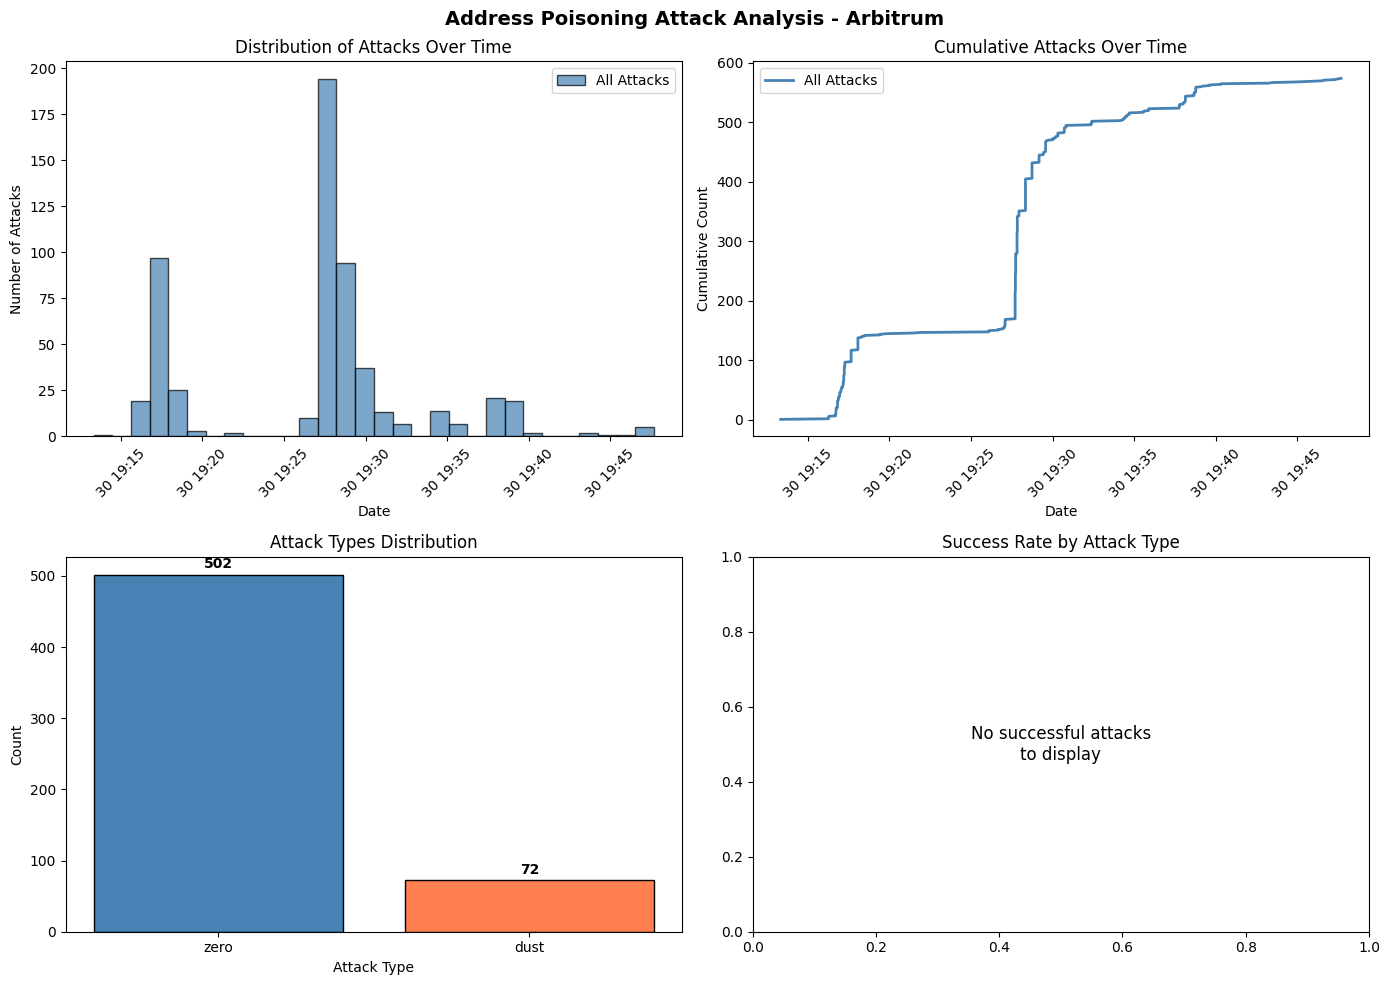

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Address Poisoning Attack Analysis - Arbitrum', fontsize=14, fontweight='bold')

# --- Plot 1: Attacks over time (histogram) ---
ax1 = axes[0, 0]
if 'block_timestamp' in step_5_df.columns:
    ax1.hist(step_5_df['block_timestamp'], bins=30, color='steelblue', edgecolor='black', alpha=0.7, label='All Attacks')
    if len(successful_attacks) > 0:
        ax1.hist(successful_attacks['block_timestamp'], bins=30, color='red', edgecolor='black', alpha=0.7, label='Successful Attacks')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Attacks')
    ax1.set_title('Distribution of Attacks Over Time')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)

# --- Plot 2: Cumulative attacks over time ---
ax2 = axes[0, 1]
if 'block_timestamp' in step_5_df.columns:
    sorted_attacks = step_5_df.sort_values('block_timestamp')
    sorted_attacks['cumulative'] = range(1, len(sorted_attacks) + 1)
    ax2.plot(sorted_attacks['block_timestamp'], sorted_attacks['cumulative'], 
             color='steelblue', linewidth=2, label='All Attacks')
    
    if len(successful_attacks) > 0:
        sorted_success = successful_attacks.sort_values('block_timestamp')
        sorted_success['cumulative'] = range(1, len(sorted_success) + 1)
        ax2.plot(sorted_success['block_timestamp'], sorted_success['cumulative'], 
                 color='red', linewidth=2, label='Successful Attacks')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Count')
    ax2.set_title('Cumulative Attacks Over Time')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

# --- Plot 3: Attack types breakdown ---
ax3 = axes[1, 0]
if 'attack_type' in step_5_df.columns:
    attack_types = step_5_df['attack_type'].value_counts()
    colors = ['steelblue', 'coral']
    bars = ax3.bar(attack_types.index, attack_types.values, color=colors[:len(attack_types)], edgecolor='black')
    ax3.set_xlabel('Attack Type')
    ax3.set_ylabel('Count')
    ax3.set_title('Attack Types Distribution')
    
    # Add value labels on bars
    for bar, val in zip(bars, attack_types.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 str(val), ha='center', va='bottom', fontweight='bold')

# --- Plot 4: Success rate by attack type ---
ax4 = axes[1, 1]
if 'attack_type' in step_5_df.columns and len(successful_attacks) > 0:
    # Calculate success rate per attack type
    success_by_type = step_5_df.groupby('attack_type').agg(
        total=('is_successful', 'count'),
        successful=('is_successful', 'sum')
    )
    success_by_type['success_rate'] = (success_by_type['successful'] / success_by_type['total'] * 100)
    
    colors = ['steelblue', 'coral']
    bars = ax4.bar(success_by_type.index, success_by_type['success_rate'], 
                   color=colors[:len(success_by_type)], edgecolor='black')
    ax4.set_xlabel('Attack Type')
    ax4.set_ylabel('Success Rate (%)')
    ax4.set_title('Success Rate by Attack Type')
    ax4.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, val in zip(bars, success_by_type['success_rate']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No successful attacks\nto display', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Success Rate by Attack Type')

plt.tight_layout()
plt.show()


In [15]:
# Additional visualization: Value stolen over time (if there are successful attacks)
if len(successful_attacks) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Successful Attack Value Analysis - Arbitrum', fontsize=14, fontweight='bold')
    
    # --- Plot 1: Value stolen distribution ---
    ax1 = axes[0]
    ax1.hist(successful_attacks['success_value_usd'], bins=20, color='darkred', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Value Stolen (USD)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Stolen Values')
    ax1.axvline(successful_attacks['success_value_usd'].median(), color='yellow', 
                linestyle='--', linewidth=2, label=f"Median: ${successful_attacks['success_value_usd'].median():,.2f}")
    ax1.legend()
    
    # --- Plot 2: Cumulative value stolen over time ---
    ax2 = axes[1]
    sorted_success = successful_attacks.sort_values('success_timestamp')
    sorted_success['cumulative_value'] = sorted_success['success_value_usd'].cumsum()
    ax2.fill_between(sorted_success['success_timestamp'], sorted_success['cumulative_value'], 
                     color='darkred', alpha=0.5)
    ax2.plot(sorted_success['success_timestamp'], sorted_success['cumulative_value'], 
             color='darkred', linewidth=2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Value Stolen (USD)')
    ax2.set_title('Cumulative Value Stolen Over Time')
    ax2.tick_params(axis='x', rotation=45)
    
    # Format y-axis as currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"\nValue Stolen Statistics:")
    print(f"  Min: ${successful_attacks['success_value_usd'].min():,.2f}")
    print(f"  Max: ${successful_attacks['success_value_usd'].max():,.2f}")
    print(f"  Mean: ${successful_attacks['success_value_usd'].mean():,.2f}")
    print(f"  Median: ${successful_attacks['success_value_usd'].median():,.2f}")
    print(f"  Total: ${successful_attacks['success_value_usd'].sum():,.2f}")
else:
    print("No successful attacks to visualize value data.")


No successful attacks to visualize value data.


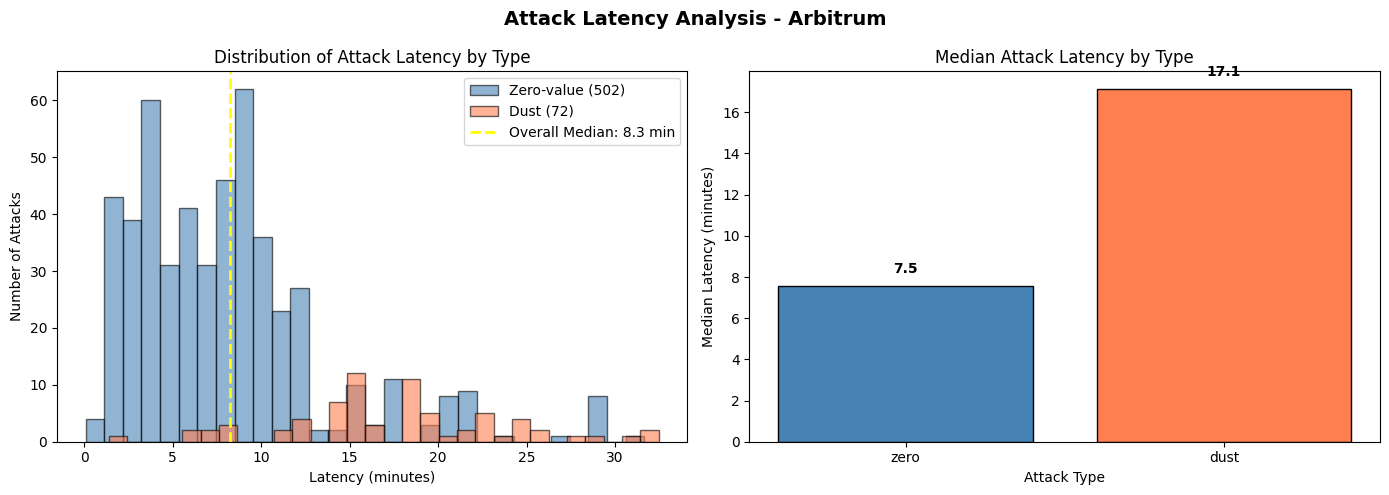


Attack Latency Statistics:
  Overall - Min: 0.08 min, Max: 32.47 min, Median: 8.26 min
  Zero - Min: 0.08 min, Max: 31.65 min, Median: 7.55 min, Count: 502
  Dust - Min: 1.40 min, Max: 32.47 min, Median: 17.13 min, Count: 72


In [16]:
# Attack Latency Analysis - Time between victim transaction and attack
if 'time_since_victim_tx' in step_5_df.columns:
    # Convert timedelta to seconds for plotting
    latency_data = step_5_df[step_5_df['time_since_victim_tx'].notna()].copy()
    latency_data['latency_seconds'] = latency_data['time_since_victim_tx'].dt.total_seconds()
    latency_data['latency_minutes'] = latency_data['latency_seconds'] / 60
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Attack Latency Analysis - Arbitrum', fontsize=14, fontweight='bold')
    
    # --- Plot 1: Distribution of attack latency by attack type ---
    ax1 = axes[0]
    if 'attack_type' in latency_data.columns:
        # Get data for each attack type
        zero_data = latency_data[latency_data['attack_type'] == 'zero']['latency_minutes']
        dust_data = latency_data[latency_data['attack_type'] == 'dust']['latency_minutes']
        
        # Plot overlapping histograms
        if len(zero_data) > 0:
            ax1.hist(zero_data, bins=30, color='steelblue', edgecolor='black', alpha=0.6, label=f'Zero-value ({len(zero_data)})')
        if len(dust_data) > 0:
            ax1.hist(dust_data, bins=30, color='coral', edgecolor='black', alpha=0.6, label=f'Dust ({len(dust_data)})')
        ax1.legend()
    else:
        ax1.hist(latency_data['latency_minutes'], bins=30, color='purple', edgecolor='black', alpha=0.7)
    
    ax1.set_xlabel('Latency (minutes)')
    ax1.set_ylabel('Number of Attacks')
    ax1.set_title('Distribution of Attack Latency by Type')
    
    # Add median line
    median_latency = latency_data['latency_minutes'].median()
    ax1.axvline(median_latency, color='yellow', linestyle='--', linewidth=2, 
                label=f'Overall Median: {median_latency:.1f} min')
    ax1.legend()
    
    # --- Plot 2: Latency by attack type (box plot for better distribution view) ---
    ax2 = axes[1]
    if 'attack_type' in latency_data.columns:
        attack_types = latency_data['attack_type'].unique()
        
        # Calculate statistics for each attack type
        stats = []
        for attack_type in attack_types:
            type_data = latency_data[latency_data['attack_type'] == attack_type]['latency_minutes']
            stats.append({
                'type': attack_type,
                'median': type_data.median(),
                'mean': type_data.mean(),
                'min': type_data.min(),
                'max': type_data.max()
            })
        
        stats_df = pd.DataFrame(stats)
        colors = ['steelblue', 'coral']
        bars = ax2.bar(stats_df['type'], stats_df['median'], color=colors[:len(stats_df)], edgecolor='black')
        ax2.set_xlabel('Attack Type')
        ax2.set_ylabel('Median Latency (minutes)')
        ax2.set_title('Median Attack Latency by Type')
        
        # Add value labels
        for bar, val in zip(bars, stats_df['median']):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                     f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print latency statistics by attack type
    print(f"\nAttack Latency Statistics:")
    print(f"  Overall - Min: {latency_data['latency_minutes'].min():.2f} min, Max: {latency_data['latency_minutes'].max():.2f} min, Median: {latency_data['latency_minutes'].median():.2f} min")
    if 'attack_type' in latency_data.columns:
        for attack_type in latency_data['attack_type'].unique():
            type_data = latency_data[latency_data['attack_type'] == attack_type]['latency_minutes']
            print(f"  {attack_type.capitalize()} - Min: {type_data.min():.2f} min, Max: {type_data.max():.2f} min, Median: {type_data.median():.2f} min, Count: {len(type_data)}")
else:
    print("No latency data available. Make sure to run Step 3 with the updated function.")
